In [1]:
from google.colab import drive

drive.mount("/content/drive/")
!unzip /content/drive/MyDrive/Senior_project/klsg_dataset.zip

Mounted at /content/drive/
Archive:  /content/drive/MyDrive/Senior_project/klsg_dataset.zip
   creating: klsg_dataset/
   creating: klsg_dataset/mine/
  inflating: klsg_dataset/mine/mine-001.jpg  
  inflating: klsg_dataset/mine/mine-002.jpg  
  inflating: klsg_dataset/mine/mine-003.jpg  
  inflating: klsg_dataset/mine/mine-004.jpg  
  inflating: klsg_dataset/mine/mine-005.jpg  
  inflating: klsg_dataset/mine/mine-006.jpg  
  inflating: klsg_dataset/mine/mine-007.jpg  
  inflating: klsg_dataset/mine/mine-008.jpg  
  inflating: klsg_dataset/mine/mine-009.jpg  
  inflating: klsg_dataset/mine/mine-010.jpg  
  inflating: klsg_dataset/mine/mine-011.jpg  
  inflating: klsg_dataset/mine/mine-012.jpg  
  inflating: klsg_dataset/mine/mine-013.jpg  
  inflating: klsg_dataset/mine/mine-014.jpg  
  inflating: klsg_dataset/mine/mine-015.jpg  
  inflating: klsg_dataset/mine/mine-016.jpg  
  inflating: klsg_dataset/mine/mine-017.jpg  
  inflating: klsg_dataset/mine/mine-018.jpg  
  inflating: klsg_dat

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from PIL import Image
import glob
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score

import torch
from torch import nn
from torch.optim import SGD
from torch.optim.lr_scheduler import StepLR

from torchvision import models
from torchvision.models import VGG19_Weights
from torchvision.transforms import transforms
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary

device = "cuda" if torch.cuda.is_available() else "cpu"

## Setup

In [3]:
df = None
for label in os.listdir("/content/klsg_dataset"):
    image_files = glob.glob(f"/content/klsg_dataset/{label}/*.jpg") + glob.glob(f"/content/klsg_dataset/{label}/*.png")
    temp = pd.DataFrame({"image_path": image_files})
    temp["label"] = label
    df = pd.concat([df, temp]) if df is not None else temp

print(df.shape)
df.head()

(1912, 2)


,image_path,label
0,/content/klsg_dataset/plane/plane-022.png,plane
1,/content/klsg_dataset/plane/plane-031.png,plane
2,/content/klsg_dataset/plane/plane-007.png,plane
3,/content/klsg_dataset/plane/plane-037.png,plane
4,/content/klsg_dataset/plane/plane-002.png,plane


In [4]:
df['label'].value_counts()

,count
label,
mine,600
seafloor,578
ship,487
victim,181
plane,66


In [5]:
le = LabelEncoder()
df['label'] = le.fit_transform(df['label'])

train_df, val_df = train_test_split(df, test_size=0.3, stratify=df['label'], random_state=42)
train_df.reset_index(drop=True, inplace=True); val_df.reset_index(drop=True, inplace=True)

print(train_df.shape, val_df.shape)
train_df.head()

(1338, 2) (574, 2)


,image_path,label
0,/content/klsg_dataset/mine/mine-311.jpg,0
1,/content/klsg_dataset/ship/ship-103.png,3
2,/content/klsg_dataset/victim/victim-121.png,4
3,/content/klsg_dataset/ship/ship-184.png,3
4,/content/klsg_dataset/mine/mine-568.jpg,0


## Data Prep

In [10]:
imagenet_stats = VGG19_Weights.IMAGENET1K_V1.transforms()

transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_stats.mean, std=imagenet_stats.std),
])

class SeabedDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx, 0]
        image = Image.open(img_path).convert('RGB')
        labels = torch.tensor(self.dataframe.loc[idx, 'label'])

        if self.transform:
            image = self.transform(image)

        return image, labels

In [11]:
# Create DataLoaders
train_dataset = SeabedDataset(train_df, transform=transform)
val_dataset = SeabedDataset(val_df, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

for batch, label in train_loader:
    print(batch.shape)
    print(label.shape)
    break

torch.Size([32, 3, 224, 224])
torch.Size([32])


## Model Training

In [12]:
class VGG19(nn.Module):
    def __init__(self):
        super().__init__()

        # load and enable pre-trained parameters for training
        self.backbone = models.vgg19(weights="DEFAULT")
        for params in self.backbone.parameters():
            params.requires_grad = True

        self.fc1 = nn.Linear(1000, 64)  # output_features from pretrained=1000
        self.fc2 = nn.Linear(64, 32)
        self.output = nn.Linear(32, len(df['label'].unique())) # Use len(label_map) for the number of output classes

        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.backbone(x)
        x = torch.flatten(x, 1) # Flatten the output of the backbone
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout(x)
        x = self.output(x)
        return x

# Initialize model
model = VGG19() # Instantiate the class
model = model.to(device) # Move the instance to the device
model = nn.DataParallel(model)

criterion = nn.CrossEntropyLoss()
optimizer = SGD(model.parameters(), lr=1e-4, momentum=0.9)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

# summary(model, train_dataset[0][0].shape)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


100%|██████████| 548M/548M [00:03<00:00, 163MB/s]


In [13]:
total_acc_train, total_loss_train = [], []
total_acc_val, total_loss_val = [], []

epochs = 10
for epoch in tqdm(range(epochs)):
    train_acc, train_loss = 0, 0
    val_acc, val_loss = 0, 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move inputs and labels to the correct device
        logit = model(inputs)

        batch_correct = (torch.argmax(logit, axis=1) == labels).sum().item()
        loss = criterion(logit, labels)

        train_acc += batch_correct
        train_loss += loss.item()

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device) # Move inputs and labels to the correct device
            logit = model(inputs).to(device)

            batch_correct = (torch.argmax(logit, axis=1) == labels).sum().item()
            loss = criterion(logit, labels)

            val_acc += batch_correct
            val_loss += loss.item()

    # finalize metrics
    train_acc = round(train_acc/train_dataset.__len__(), 4)
    train_loss = round(train_loss/1000, 4)
    val_acc = round(val_acc/val_dataset.__len__(), 4)
    val_loss = round(val_loss/1000, 4)

    # store score of epoch
    total_acc_train.append(train_acc)
    total_acc_val.append(val_acc)
    total_loss_train.append(train_loss)
    total_loss_val.append(val_loss)

    print(f"\n=========== Epoch {epoch+1} ===========")
    print(f"Train: acc -> {train_acc} / loss -> {train_loss}")
    print(f"Val: acc -> {val_acc} / loss -> {val_loss}")

 10%|█         | 1/10 [00:28<04:18, 28.74s/it]


=========== Epoch 1 ===========
Train: acc -> 0.4507 / loss -> 0.0564
Val: acc -> 0.6899 / loss -> 0.0163


 20%|██        | 2/10 [00:56<03:45, 28.14s/it]


=========== Epoch 2 ===========
Train: acc -> 0.7489 / loss -> 0.032
Val: acc -> 0.7875 / loss -> 0.0111


 30%|███       | 3/10 [01:24<03:16, 28.06s/it]


=========== Epoch 3 ===========
Train: acc -> 0.8161 / loss -> 0.0241
Val: acc -> 0.838 / loss -> 0.0098


 40%|████      | 4/10 [01:52<02:49, 28.24s/it]


=========== Epoch 4 ===========
Train: acc -> 0.8475 / loss -> 0.0191
Val: acc -> 0.878 / loss -> 0.0082


 50%|█████     | 5/10 [02:22<02:23, 28.69s/it]


=========== Epoch 5 ===========
Train: acc -> 0.8655 / loss -> 0.0169
Val: acc -> 0.8763 / loss -> 0.0076


 60%|██████    | 6/10 [02:52<01:55, 29.00s/it]


=========== Epoch 6 ===========
Train: acc -> 0.8999 / loss -> 0.0151
Val: acc -> 0.899 / loss -> 0.0067


 70%|███████   | 7/10 [03:21<01:27, 29.06s/it]


=========== Epoch 7 ===========
Train: acc -> 0.9141 / loss -> 0.0132
Val: acc -> 0.9094 / loss -> 0.0064


 80%|████████  | 8/10 [03:50<00:58, 29.19s/it]


=========== Epoch 8 ===========
Train: acc -> 0.923 / loss -> 0.012
Val: acc -> 0.9268 / loss -> 0.0049


 90%|█████████ | 9/10 [04:20<00:29, 29.26s/it]


=========== Epoch 9 ===========
Train: acc -> 0.9268 / loss -> 0.0108
Val: acc -> 0.9094 / loss -> 0.0055


100%|██████████| 10/10 [04:49<00:00, 28.96s/it]


=========== Epoch 10 ===========
Train: acc -> 0.9215 / loss -> 0.0102
Val: acc -> 0.9251 / loss -> 0.0047


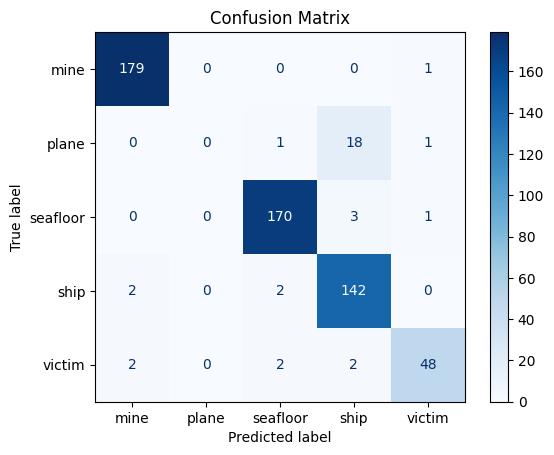

              precision    recall  f1-score   support

        mine       0.98      0.99      0.99       180
       plane       0.00      0.00      0.00        20
    seafloor       0.98      0.99      0.98       174
        ship       0.88      0.97      0.92       146
      victim       0.93      0.93      0.93        54

    accuracy                           0.95       574
   macro avg       0.75      0.78      0.76       574
weighted avg       0.91      0.95      0.93       574



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [20]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate the confusion matrix
cm = confusion_matrix(true_labels, predictions, labels=le.transform(class_names))

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Make predictions on the validation set
model.eval()
predictions = []
true_labels = []
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# Get the class names from the LabelEncoder
class_names = le.classes_

# Generate and print the classification report
report = classification_report(true_labels, predictions, target_names=class_names)
print(report)

## YOLO

In [21]:
!pip install -q ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.9 MB/s eta 0:00:00


In [22]:
import cv2
import shutil
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [24]:
train_df['label'] = le.inverse_transform(train_df['label'])
val_df['label'] = le.inverse_transform(val_df['label'])

for label in tqdm(os.listdir("/content/klsg_dataset")):
    os.makedirs(f'/content/yolo_data/train/{label}', exist_ok=True)
    os.makedirs(f'/content/yolo_data/val/{label}', exist_ok=True)

for _, row in train_df.iterrows():
    shutil.copy(row['image_path'], f'/content/yolo_data/train/{row["label"]}/{row["image_path"].split("/")[-1]}')
for _, row in val_df.iterrows():
    shutil.copy(row['image_path'], f'/content/yolo_data/val/{row["label"]}/{row["image_path"].split("/")[-1]}')

100%|██████████| 5/5 [00:00<00:00, 6765.01it/s]


In [25]:
# Define the number of classes
num_classes = len(le.classes_)

# Create a data.yaml file for YOLO
data_yaml_content = f"""
path: /content/yolo_data
train: train/
val: val/
nc: {num_classes}
names: {list(le.classes_)}
"""

with open("/content/yolo_data/data.yaml", "w") as f:
    f.write(data_yaml_content)

print("data.yaml created.")

data.yaml created.


In [26]:
model = YOLO("yolo11n-cls.pt")

results = model.train(data="/content/yolo_data/", epochs=10, imgsz=224)

Ultralytics 8.3.192 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/yolo_data/, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=224, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n-cls.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=True

/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1357: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1359: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic 

AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3125.6±1739.4 MB/s, size: 255.2 KB)
train: Scanning /content/yolo_data/train... 1338 images, 0 corrupt: 100% ━━━━━━━━━━━━ 1338/1338 2078.7it/s 0.6s
train: New cache created: /content/yolo_data/train.cache
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1280.9±849.9 MB/s, size: 220.4 KB)
val: Scanning /content/yolo_data/val... 574 images, 0 corrupt: 100% ━━━━━━━━━━━━ 574/574 2269.5it/s 0.3s
val: New cache created: /content/yolo_data/val.cache
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001111, momentum=0.9) with parameter groups 39 weight(decay=0.0), 40 weight(decay=0.0005), 40 bias(decay=0.0)
Image sizes 224 train, 224 val
Using 8 dataloader workers
Logging results to runs/classify/train
Starting training for 10 epochs...

      Epoch    GPU_mem       loss  Instances       Size


/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1357: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1359: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic 

       1/10      6.03G      2.019         16        224: 2% ──────────── 2/84 5.2it/s 2.2s<15.7s

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1357: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(t

       1/10      6.04G     0.7925         10        224: 100% ━━━━━━━━━━━━ 84/84 11.4it/s 7.4s
               classes   top1_acc   top5_acc: 100% ━━━━━━━━━━━━ 18/18 12.9it/s 1.4s
                   all      0.939          1

      Epoch    GPU_mem       loss  Instances       Size
       2/10      6.04G     0.3633         16        224: 2% ──────────── 2/84 5.1it/s 0.1s<16.2s

/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1357: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1359: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic 

       2/10      6.04G      0.237         10        224: 100% ━━━━━━━━━━━━ 84/84 22.9it/s 3.7s
               classes   top1_acc   top5_acc: 100% ━━━━━━━━━━━━ 18/18 37.3it/s 0.5s
                   all      0.956          1

      Epoch    GPU_mem       loss  Instances       Size
       3/10      6.05G     0.1402         16        224: 2% ──────────── 2/84 4.6it/s 0.1s<17.7s

/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1357: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1359: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic 

       3/10      6.05G     0.2663         10        224: 100% ━━━━━━━━━━━━ 84/84 23.1it/s 3.6s
               classes   top1_acc   top5_acc: 100% ━━━━━━━━━━━━ 18/18 39.8it/s 0.5s
                   all      0.963          1

      Epoch    GPU_mem       loss  Instances       Size
       4/10      6.06G     0.0774         16        224: 1% ──────────── 1/84 2.5it/s 0.1s<32.9s

/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1357: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1359: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic 

       4/10      6.06G     0.2185         10        224: 100% ━━━━━━━━━━━━ 84/84 22.9it/s 3.7s
               classes   top1_acc   top5_acc: 100% ━━━━━━━━━━━━ 18/18 35.2it/s 0.5s
                   all      0.974          1

      Epoch    GPU_mem       loss  Instances       Size
       5/10      6.07G     0.1152         16        224: 5% ╸─────────── 4/84 10.7it/s 0.2s<7.5s

/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1357: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1359: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic 

       5/10      6.07G     0.1795         10        224: 100% ━━━━━━━━━━━━ 84/84 23.8it/s 3.5s
               classes   top1_acc   top5_acc: 100% ━━━━━━━━━━━━ 18/18 41.4it/s 0.4s
                   all      0.962          1

      Epoch    GPU_mem       loss  Instances       Size
       6/10      6.08G     0.1922         16        224: 2% ──────────── 2/84 5.1it/s 0.1s<16.0s

/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1357: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1359: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic 

       6/10      6.08G     0.1571         10        224: 100% ━━━━━━━━━━━━ 84/84 24.0it/s 3.5s
               classes   top1_acc   top5_acc: 100% ━━━━━━━━━━━━ 18/18 32.4it/s 0.6s
                   all      0.958          1

      Epoch    GPU_mem       loss  Instances       Size
       7/10      6.09G     0.1021         16        224: 2% ──────────── 2/84 4.7it/s 0.1s<17.5s

/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1357: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1359: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic 

       7/10      6.09G     0.1309         10        224: 100% ━━━━━━━━━━━━ 84/84 23.2it/s 3.6s
               classes   top1_acc   top5_acc: 100% ━━━━━━━━━━━━ 18/18 40.0it/s 0.5s
                   all      0.965          1

      Epoch    GPU_mem       loss  Instances       Size
       8/10       6.1G     0.1527         16        224: 2% ──────────── 2/84 5.5it/s 0.1s<15.0s

/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1357: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1359: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic 

       8/10       6.1G     0.1182         10        224: 100% ━━━━━━━━━━━━ 84/84 24.4it/s 3.4s
               classes   top1_acc   top5_acc: 100% ━━━━━━━━━━━━ 18/18 38.0it/s 0.5s
                   all      0.979          1

      Epoch    GPU_mem       loss  Instances       Size
       9/10       6.1G    0.05033         16        224: 2% ──────────── 2/84 4.4it/s 0.1s<18.8s

/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1357: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1359: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic 

       9/10      6.11G    0.09765         10        224: 100% ━━━━━━━━━━━━ 84/84 23.7it/s 3.5s
               classes   top1_acc   top5_acc: 100% ━━━━━━━━━━━━ 18/18 30.6it/s 0.6s
                   all      0.974          1

      Epoch    GPU_mem       loss  Instances       Size
      10/10      6.11G     0.1459         16        224: 2% ──────────── 2/84 4.4it/s 0.1s<18.8s

/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1357: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1359: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic 

      10/10      6.11G    0.06982         10        224: 100% ━━━━━━━━━━━━ 84/84 23.2it/s 3.6s
               classes   top1_acc   top5_acc: 100% ━━━━━━━━━━━━ 18/18 38.1it/s 0.5s
                   all      0.976          1

10 epochs completed in 0.014 hours.
Optimizer stripped from runs/classify/train/weights/last.pt, 3.2MB
Optimizer stripped from runs/classify/train/weights/best.pt, 3.2MB

Validating runs/classify/train/weights/best.pt...
Ultralytics 8.3.192 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n-cls summary (fused): 47 layers, 1,532,429 parameters, 0 gradients, 3.2 GFLOPs
train: /content/yolo_data/train... found 1338 images in 5 classes ✅ 
val: /content/yolo_data/val... found 574 images in 5 classes ✅ 
test: None...
               classes   top1_acc   top5_acc: 100% ━━━━━━━━━━━━ 18/18 40.1it/s 0.4s
                   all      0.979          1
Speed: 0.1ms preprocess, 0.4ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/class

In [27]:
predictions = []
for img in tqdm(val_df['image_path']):
    result = model.predict(img, verbose=False)
    label_map = result[0].names
    pred = label_map[result[0].probs.top1]
    predictions.append(pred)

val_df['pred'] = predictions

100%|██████████| 574/574 [00:05<00:00, 102.68it/s]


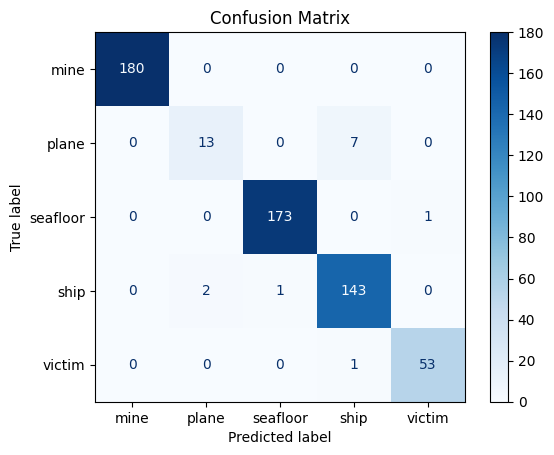

              precision    recall  f1-score   support

        mine       1.00      1.00      1.00       180
       plane       0.87      0.65      0.74        20
    seafloor       0.99      0.99      0.99       174
        ship       0.95      0.98      0.96       146
      victim       0.98      0.98      0.98        54

    accuracy                           0.98       574
   macro avg       0.96      0.92      0.94       574
weighted avg       0.98      0.98      0.98       574



In [28]:
# Generate the confusion matrix
cm = confusion_matrix(val_df['label'], val_df['pred'], labels=le.classes_)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

print(classification_report(val_df['label'], val_df['pred']))

              precision    recall  f1-score   support

        mine       1.00      1.00      1.00       180
       plane       0.93      0.65      0.76        20
    seafloor       1.00      0.99      1.00       174
        ship       0.95      0.99      0.97       146
      victim       0.98      1.00      0.99        54

    accuracy                           0.98       574
   macro avg       0.97      0.93      0.95       574
weighted avg       0.98      0.98      0.98       574

